# Convolutional Variation Autoencoder for MNIST

This notebook implements a Convolutional Variational Autoencoder for MNIST. The goal of this notebook is to gain more familiarity with PyTorch, Recap my understanding of Convolutional Networks, and build a framework for scaling image generation to more complex image datasets. A more in depth explanation of how Variational Autoencoders work, see my notebook Variational_Autoencoder_MNIST.ipynb.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Load Data

Here I load the mnist, transform it to tensor data, and wrap in a data loader for test and train.

In [32]:
# Define a transform to convert the PIL images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset with the transformation
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap in a DataLoader
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=128, shuffle=True)

# Model 

Below is my implementation of a Convolutional VAE for MNIST. I will describe one forward pass of the model below.

A [batch, 1, 28, 28] tensor containing a batch of mnist digits is fed into encoder. The encoder consists of 3 convolutional blocks. All the Conv2d layers within them have a (3x3) kernel size with a stride of 1 and 1 padding. This means that the recpetive field is a 3x3 grid that "scans" across the image moving one pixel at a time. At each location of the "scan" matrix operations are applied to the 3x3 grid to extract features while deepenign the number of image channels. These new image channels are refered to as feature maps.

There are two conv layers in each conv block followed by max pooling which reduces the spatial dimmension of the image by half. This is done by "scanning" the image in the same way as the conv2d layers, but instead of applying filters and creating feature maps, At each "scan" location the max pixel value is extracted. A stride of 2 is used to ensure the image reduces in dimmensionality by half for each dimmension, keeping the extracted max value. 

The 3 conv blocks increase the feature maps from 1 --> 8 --> 16 --> 32   which means the output size of the final conv block, taking into account max pooling, is [batch, 32, 3, 3]. This image data is then flattened to [batch, 288] and output from the decoder. 

This output is then fed into two respective linear layers that reduce the dimmensionality to [batch, 50]. These two resultant tensors will serve as the mean and log variance of the latent representation. These statistics will be fed into the reparemtrization trick, which transforms a sampling of the standard normal distribution to the gaussian distribution these statistics represent. 

This distribution is then fed into the decoder, brought back to the flattened latent dimmension size of [batch 288] using a linear layer, then reshaping to [batch, 32, 3, 3,]. This tensors is then passed through the reverse of the encoder (conv2dtranspose), with the one difference of zero padding added just before the final output to counterbalance dimmensionality loss from convolution.

This output is the decoded image


The loss defined is the reconstructrion loss plus the KL Divergence loss which optimizes for both the decoded output to be the same as input and that the latent distribution is as close to the standard normal distribution so to introduce generative capabilities into the model.

In [51]:
class VAE(nn.Module):
    def __init__(self, input_channels, flattned_output_dim, latent_distr_dim):
        super(VAE, self).__init__()
        self.input_dim = input_channels
        self.flattned_output_dim = flattned_output_dim
        self.latent_dim = latent_distr_dim

        # Encoder
        self.encoder = nn.Sequential(
            #conv block 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #conv block 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #conv block 3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten())
            

        # Separate layers for computing mean and log variance in the Latent space
        self.mu = nn.Linear(flattned_output_dim, latent_distr_dim)
        self.logvar = nn.Linear(flattned_output_dim, latent_distr_dim)

        # Decoder
        self.decoder = nn.Sequential(        
            nn.Linear(latent_distr_dim, flattned_output_dim), #bring the latent to the shape of the flattened last conv block
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)), #reshape to the shape of the last conv block

            #deconv block 1
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            #deconv block 2
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            #deconv block 3
            nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),

            nn.Sigmoid(),
            nn.ZeroPad2d(padding=2) ) #padd zeros to return [batch_size, 1, 24, 24] to [batch_size, 1, 28, 28])
    
    def reparametrize(self, mu, logvar):
        '''
        With the mean and the std of the encoded input,transform aa sample of the standard 
        normal distribution N(), 1) to the distribution of the encoded input by z = mu + std*eps
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x) #encode the input, return its flattened form
        mu, logvar = self.mu(encoded), self.logvar(encoded) #get the mean and the log of the variance
        reparametrized = self.reparametrize(mu, logvar) #reparametrize
        decoded = self.decoder(reparametrized) #decode the reparametrized latent
        return decoded, mu, logvar
    
    def loss(self, input, decoded, mu, logvar):
        '''
        The KL divergence loss measures the difference between the standard
        normal distribution and the distribution defined by the encoder 
        output's mean and variance. The reconstruction loss measures the
        difference between the decoded output and the input.
        '''
        recon_loss = F.binary_cross_entropy(decoded, input, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return recon_loss + kl_divergence #total loss

# Training Loop

Below is the training loop which uses early stopping to regulate epochs. It is fairly standard.

In [53]:
vae = VAE(input_channels=1, flattned_output_dim=32*3*3, latent_distr_dim=50)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Data will be loaded to: {device} \n')

epochs = 1000

#early stopping
patience, counter, min_loss = 5, 0, np.Inf

for epoch in range(epochs):
    for i, (data, _) in enumerate(train_loader):
        inputs = data.to(device)
        decoded, mu, logvar = vae(inputs)
        loss = vae.loss(inputs, decoded, mu, logvar)

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights

    decoded, mu, logvar = vae(inputs)
    loss = vae.loss(inputs, decoded, mu, logvar)
    
    if epoch % 5 == 0 or epoch == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

    #early stopping
    if loss.item() < min_loss:
        min_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch: {epoch} \nFinal Loss was {loss.item():.4f}')
            break

Data will be loaded to: cpu 

Epoch: 0, Loss: 16043.7998
Epoch: 5, Loss: 12597.4639
Early stopping at epoch: 7 
Final Loss was 13705.1318


# Using the VAE as an Autoencoder

Below I show a visualization of what the VAE does to the input, the middle row shows the distribution resulting from the reparamatrization trick.

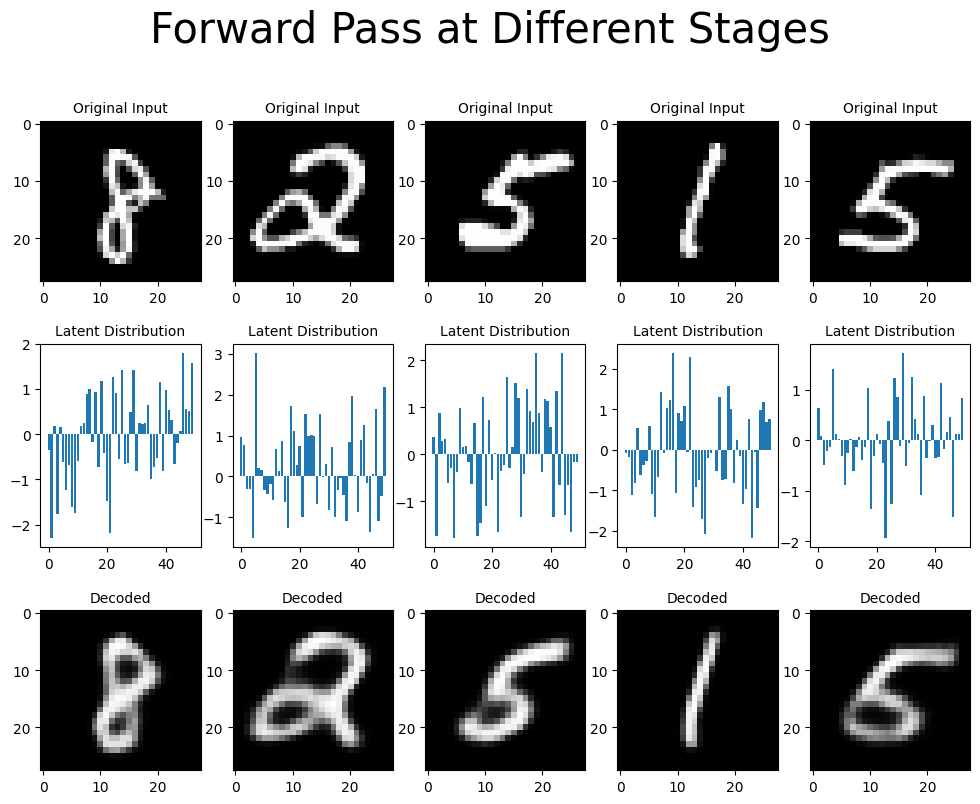

In [62]:
decoded, mu, logvar = vae(inputs)

fig, ax = plt.subplots(3, 5, figsize=(12, 9))
fig.suptitle("Forward Pass at Different Stages", fontsize = 30)

for i in range(5):
    #original image
    image = inputs[i].cpu().view(28, 28).detach().numpy()
    ax[0][i].imshow(image, cmap='gray')
    #set title of each subplot
    ax[0][i].set_title("Original Input", fontsize=10)

    #latent distribution bar plot
    distribution = vae.reparametrize(mu[i].cpu().detach(), logvar[i].cpu().detach())
    ax[1][i].bar(np.arange(50), distribution)
    ax[1][i].set_title("Latent Distribution", fontsize=10)  

    #decoded image
    image = decoded[i].cpu().view(28, 28).detach().numpy()
    ax[2][i].imshow(image, cmap='gray')
    ax[2][i].set_title("Decoded", fontsize=10)



# Generation of New Samples

Additionally, below are generated samples created by feeding a sample from the standard normal distribution into the decoder.

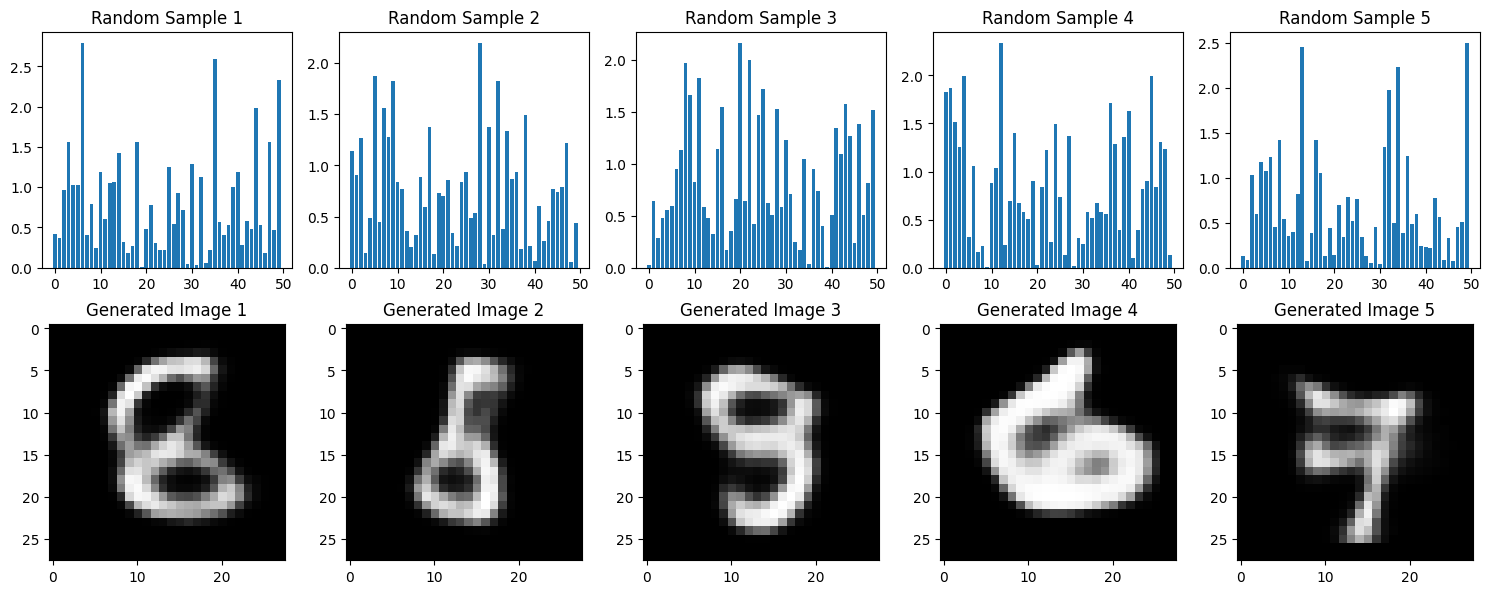

In [55]:
standard_sample = torch.randn(64, 50).to(device) # Generate a random tensor of size (64, 20)
generated = vae.decoder(standard_sample) # Pass the random tensor through the decoder

fig, axs = plt.subplots(2, 5, figsize=(15,6)) 

# Reshape the generated data back into images
generated_images = generated.view(-1, 28, 28).cpu().detach().numpy()

# Plotting the random samples
for i, ax in enumerate(axs[0]):
    ax.bar(np.arange(50), np.abs(standard_sample[i].cpu().numpy()))
    ax.set_title(f"Random Sample {i+1}")

# Plotting the generated images
for i, ax in enumerate(axs[1]):
    ax.imshow(generated_images[i], cmap='gray')
    ax.set_title(f"Generated Image {i+1}")

plt.tight_layout()
plt.show()